<a href="https://colab.research.google.com/github/daspartho/DiffEdit/blob/main/DiffEdit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Imports

In [80]:
!pip install diffusers transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [81]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler
import torch
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from PIL import Image
from IPython import display
import logging
from pathlib import Path
from huggingface_hub import notebook_login

logging.disable(logging.WARNING)

if not (Path.home()/'.huggingface'/'token').exists(): 
    notebook_login()

### Loading the Models

In [82]:
tokenizer = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
)

text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14",
    torch_dtype = torch.float16,
).to("cuda")

vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "vae",
    torch_dtype = torch.float16,
).to("cuda")

unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    subfolder = "unet",
    torch_dtype = torch.float16,
).to("cuda")

beta_start,beta_end = 0.00085,0.012
scheduler = DDIMScheduler(
    beta_start=beta_start,
    beta_end=beta_end,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
    clip_sample=False, 
    set_alpha_to_one=False,
)

### Decoding Encoding functions

In [83]:
def encode(img):
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(img).unsqueeze(0).to("cuda").half())
        latent = 0.18215 * latent.latent_dist.sample()
    return latent

def decode(latent):
    latent = (1 / 0.18215) * latent
    with torch.no_grad():
        img = vae.decode(latent).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(0, 2, 3, 1).numpy()
    img = (img * 255).round().astype("uint8")
    return Image.fromarray(img[0])

### Function to turn prompts in embeddings

In [84]:
def prep_text(prompt):

    text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    text_embedding = text_encoder(
        text_input.input_ids.to("cuda")
    )[0].half()

    uncond_input = tokenizer(
        [""],
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

    uncond_embedding = text_encoder(
        uncond_input.input_ids.to("cuda")
    )[0].half()

    return torch.cat([uncond_embedding, text_embedding])

## Step 1: Get the Mask

### Img2Img pipeline

In [85]:
def Img2Img(
    prompt,
    img, 
    steps=50,
    guidance_scale=7.5, 
    start_step=20,
    seed=32
    ):

    prompt = [prompt]
    text_embeddings = prep_text(prompt)

    scheduler.set_timesteps(steps)

    width, height = img.size
    encoded = encode(img)

    torch.manual_seed(seed)
    noise = torch.randn(
        (1,unet.in_channels,height // 8,width // 8),
    ).to("cuda").half()

    latents = scheduler.add_noise(
        encoded, 
        noise, 
        timesteps=torch.tensor([scheduler.timesteps[start_step]])
    )

    for i, t in enumerate(tqdm(scheduler.timesteps)):
        if i > start_step:
            input = torch.cat([latents]*2)
            input = scheduler.scale_model_input(input, t)

            with torch.no_grad():
                pred = unet(
                    input, 
                    t,
                    encoder_hidden_states=text_embeddings,
                ).sample

            pred_uncond, pred_text = pred.chunk(2)
            pred = pred_uncond + guidance_scale * (pred_text - pred_uncond)

            latents = scheduler.step(pred, t, latents).prev_sample

    return decode(latents)

### Get the input image

In [86]:
!curl --output test.jpg 'https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.wallpapers13.com%2Fwp-content%2Fuploads%2F2016%2F02%2FBeautiful-Brown-Horse-grass-field-with-clouds-hd-wallpaper-1280x960.jpg&f=1&nofb=1&ipt=7f3a1529c5ee6d13c8ee78b73a1e6696dc4f97d8942cdaf164d9eb92fd06fdac&ipo=images'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  201k    0  201k    0     0   109k      0 --:--:--  0:00:01 --:--:--  109k


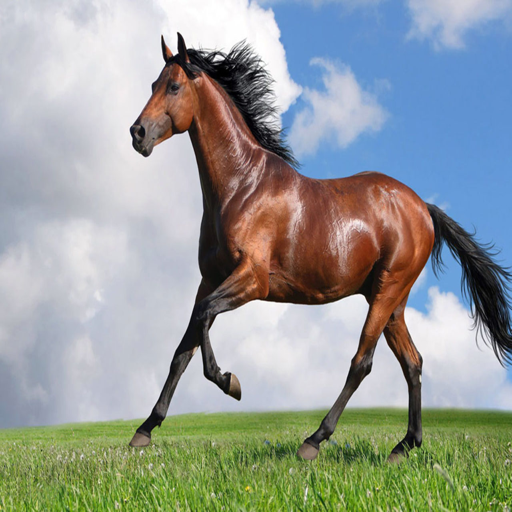

In [87]:
img = Image.open('test.jpg').resize((512, 512))
display.display(img)

### Denoising noised input image

In [88]:
query = "zebra"
ref = "horse"

#### Denoising on query text

  0%|          | 0/50 [00:03<?, ?it/s]

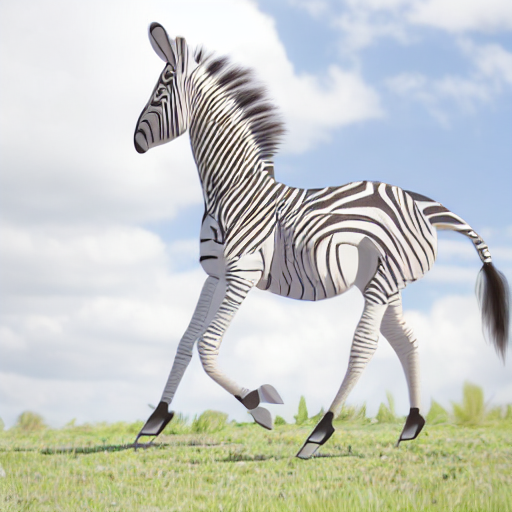

In [89]:
query_img = Img2Img(query,img,)
display.display(query_img)

#### Denoising on reference text

  0%|          | 0/50 [00:00<?, ?it/s]

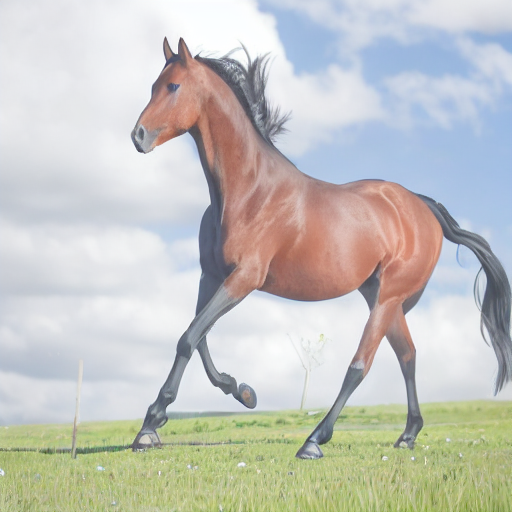

In [90]:
ref_img = Img2Img(ref, img)
display.display(ref_img)